# Parsing links for phones from gsmarena website

## Getting relevant brands first pages.

On gsmarena website there are several brands of phones listed under all brands section, as can be seen on the photo below. In order to get links to all the phones from all brands the script will have to go to each brands first page, collect all the phones listed on the page. Optionally, if there are several pages, the script will go through all of them in order to collect all the relevant links.

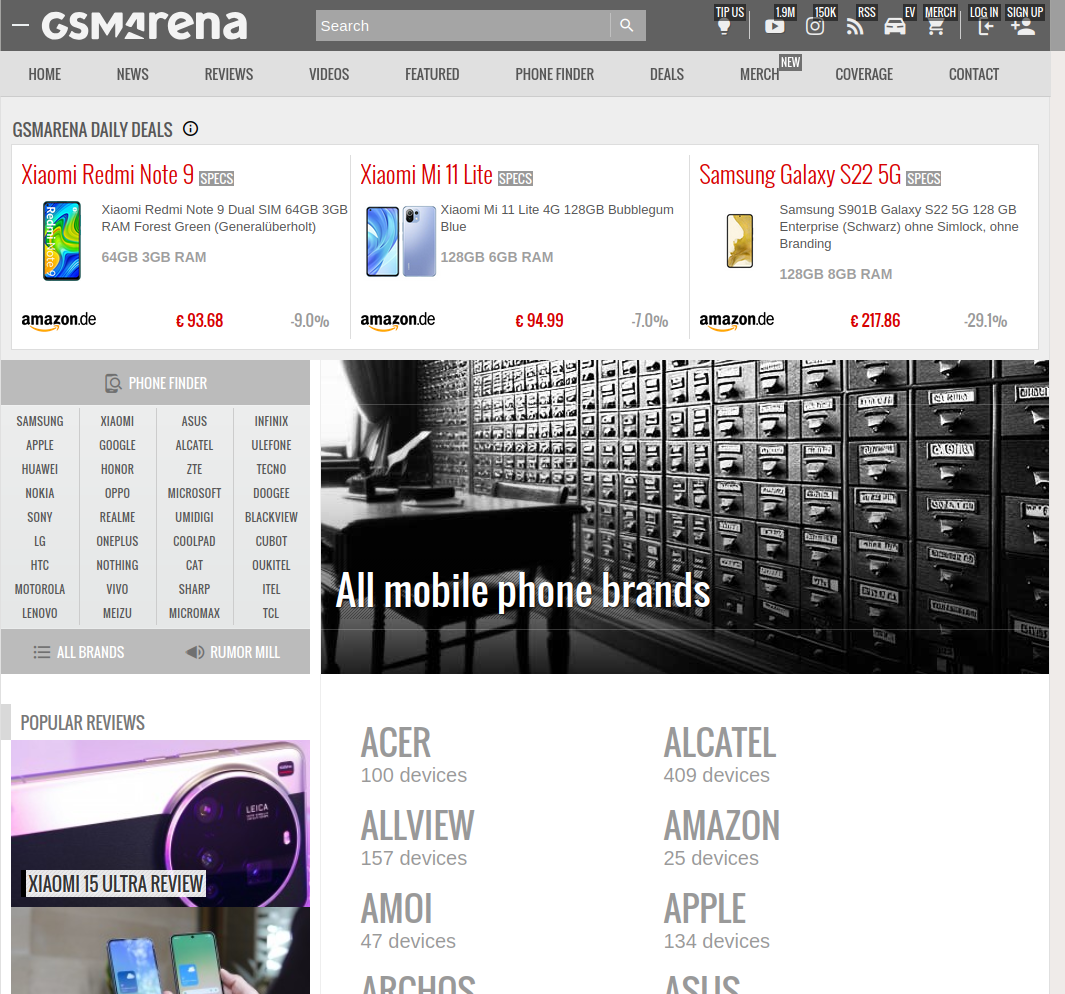

In [10]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin
import time
import random

In [2]:
user_agent = 'Mozilla/5.0 (X11; Linux x86_64; rv:136.0) Gecko/20100101 Firefox/136.0' # User agent is needed to scrap the websites

The script will collect the links to all the brands listed. As can be seen on the screenshot below, all the relvant links are available within a div with class="st-text". The knowladge about the div class will help identify the links which are needed to be scrapped.

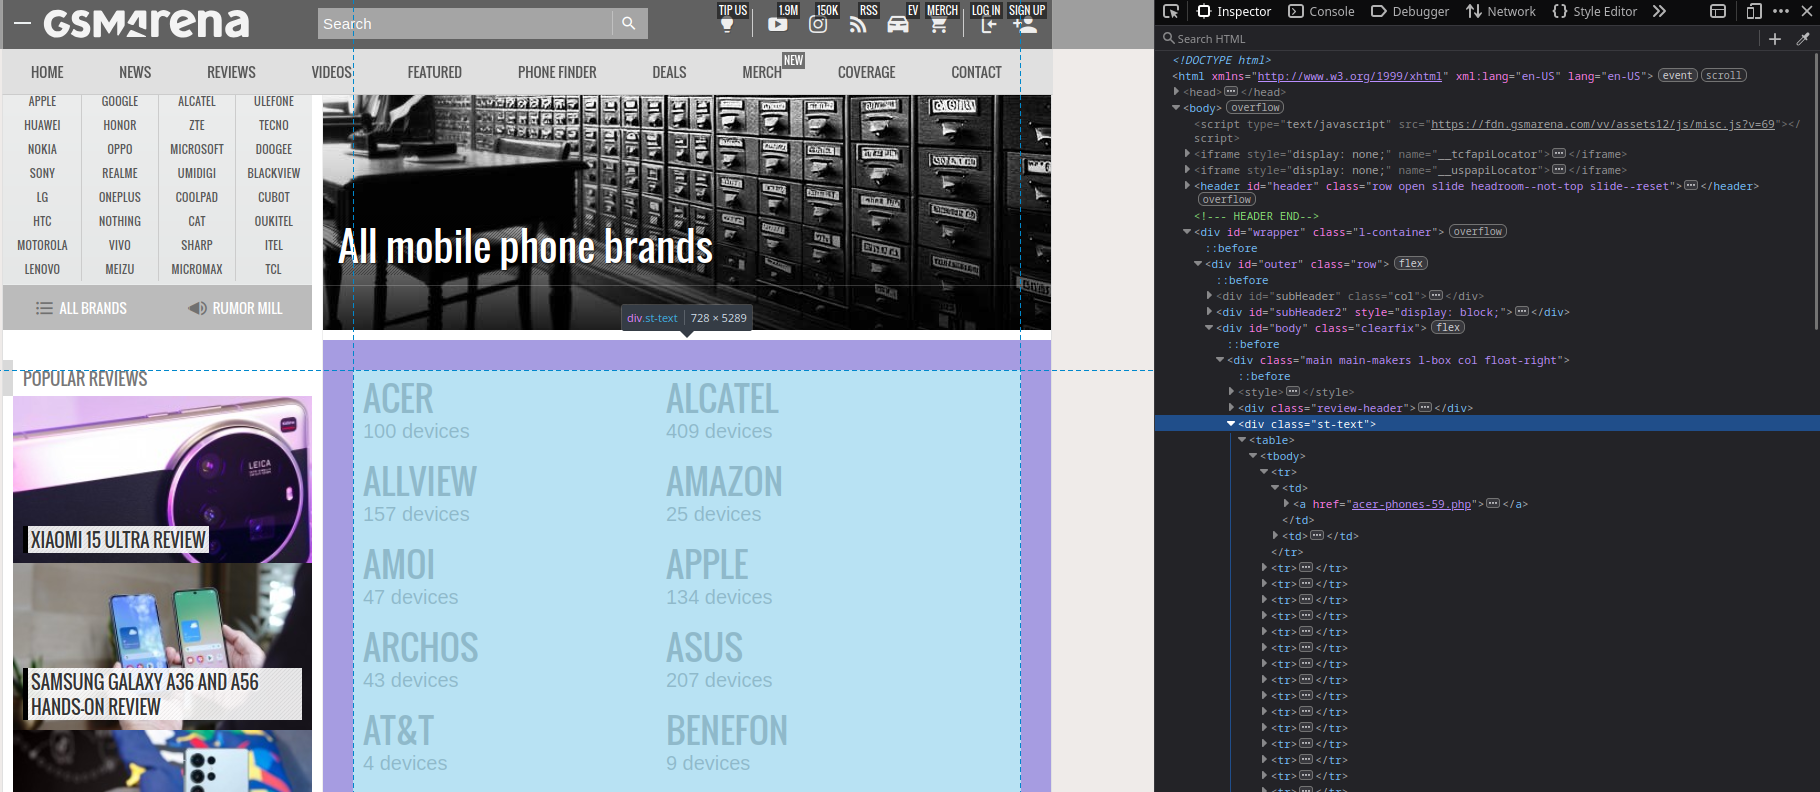

A single get request will be enough to get all the relevant data about all the brands phones first pages.

In [3]:
all_brands_page = 'https://www.gsmarena.com/makers.php3'
all_first_pages = []

response = requests.get(all_brands_page, headers = {'User-agent': user_agent})

# Check if the request was successful
if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

    # FInd the div and find all the a tags with href in them.
    links = soup.find('div', class_='st-text').find_all('a', href=True)
    
    all_first_pages = [urljoin('https://www.gsmarena.com/',link['href']) for link in links]
    time.sleep(2)

In [12]:
(all_first_pages[:5],
 len(all_first_pages))

(['https://www.gsmarena.com/acer-phones-59.php',
  'https://www.gsmarena.com/alcatel-phones-5.php',
  'https://www.gsmarena.com/allview-phones-88.php',
  'https://www.gsmarena.com/amazon-phones-76.php',
  'https://www.gsmarena.com/amoi-phones-28.php'],
 125)

All looks good!

## Link parser
### Helper function
`get_links` is a helper function which will get the links from a BeautifulSoup object.

Firstly, it finds the div with class 'makers', which contains the links to the phones. Afterwards, it finds all the \<a> tags wich have an href attribute. Finally, it returns a list of complete links to the phones page.

In [4]:
def get_links(soup: BeautifulSoup) -> list:
    # Find all links in a div where models are listed
    links = soup.find('div', class_='makers').find_all('a', href=True)
    
    # Return a list with complete links
    return [urljoin('https://www.gsmarena.com/',link['href']) for link in links]

In [5]:
# Test the function with basic example
html = '''
<div class="makers">
    <a href="model1.php">Model 1</a>
    <a href="/model2.php">Model 2</a>
    <a href="https://www.gsmarena.com/model3.php">Model 3</a>
</div>
'''

soup = BeautifulSoup(html, 'html.parser')
urls = get_links(soup)
print(urls)

['https://www.gsmarena.com/model1.php', 'https://www.gsmarena.com/model2.php', 'https://www.gsmarena.com/model3.php']


The helper function returns the correct result regardless of the format of a \<a> tag

### Main function

`get_all_links` returns a list of all links to phone models for a given link, which should be the first page of catalogue with phones

It will go to first page of a brand and get all the links from div class makers, where all the relevant phone links reside. After that, the script will try to find a pagenation link. If it is present, then it will go to next page, else it will finish with the brand. Pagenation link from gsmarena website can be seen in picture below:

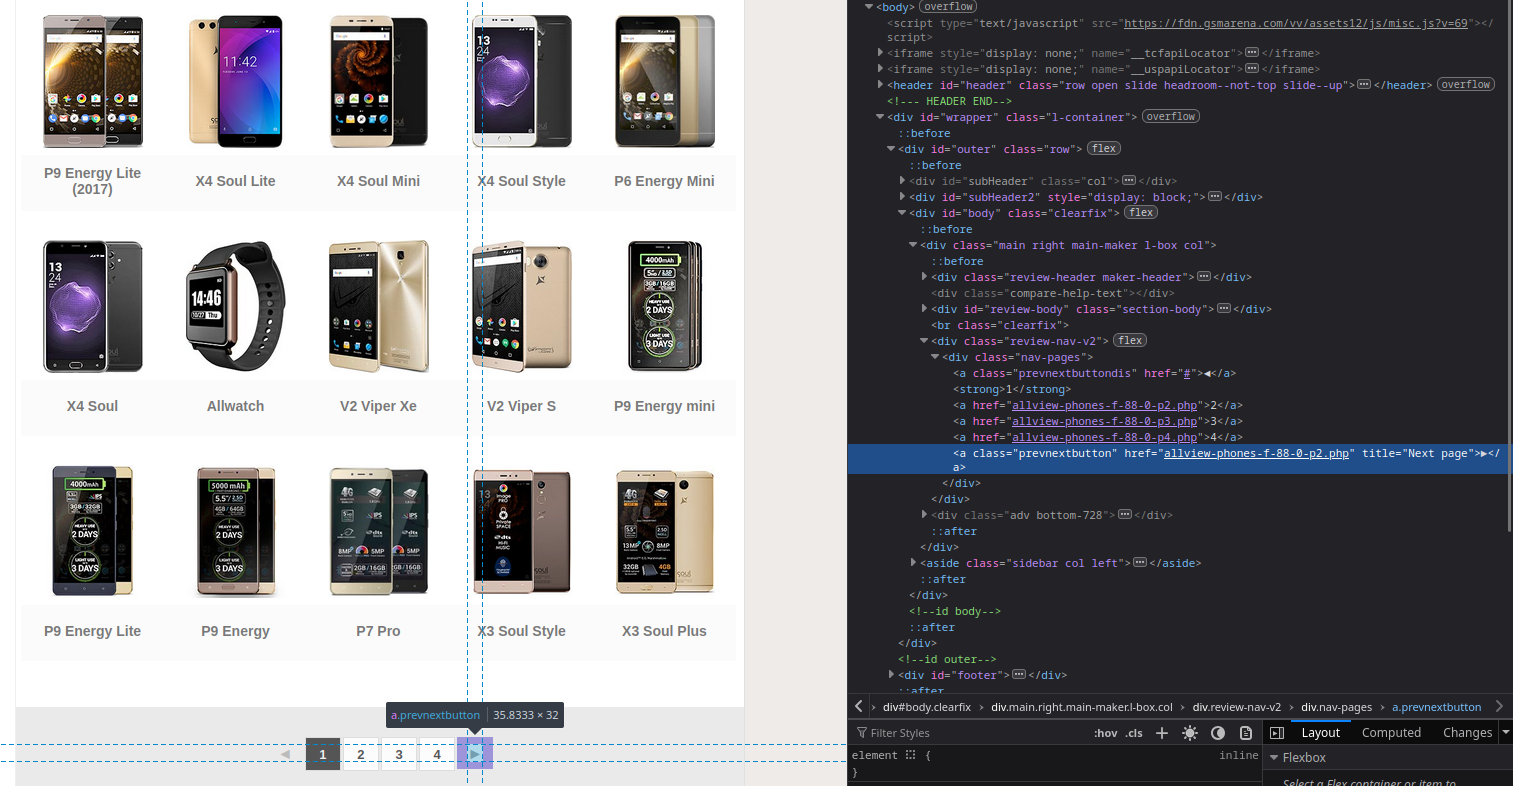

In [11]:
def get_all_links(first_link: str) -> list:
    # Current url wich will change if a pagination link is found. If the pagination link is not found, assigned to ''.
    current_url = first_link

    # URLS which will be returned
    urls = []

    while current_url:
        # Send a GET request to the webpage
        response = requests.get(current_url, headers = {'User-agent': user_agent})

        # Check if the request was successful
        if response.status_code == 200:
            # Parse the response text with BeautifulSoup
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Extend urls with the links returned from get_links in a response
            urls.extend(get_links(soup))

            # Find the pagination link
            pagination_link = soup.find('a', class_='prevnextbutton', title='Next page', href=True)

            if pagination_link:
                # Update the current page URL to the next page
                current_url = urljoin('https://www.gsmarena.com/', pagination_link['href'])
                print(f'Going to {current_url}')
            else:
                print(f'Finished with brand {current_url}')
                # No more pagination link found, exit the loop
                current_url = ''

            # Wait 2 second before another request because the script will get timed out without it.
            time.sleep(random.uniform(2, 3))
        else:
            print(f"Failed to retrieve the webpage. Status code: {response.status_code}")
            current_url = ''
    return urls

## Getting the links

I will test the function with the first brand in the list of brands

In [9]:
first_brand_test = list()
first_brand_test.extend(get_all_links(all_first_pages[0]))
(first_brand_test[:5],
 len(first_brand_test))

Going to https://www.gsmarena.com/acer-phones-f-59-0-p2.php
Going to https://www.gsmarena.com/acer-phones-f-59-0-p3.php
Finished with brand https://www.gsmarena.com/acer-phones-f-59-0-p3.php


(['https://www.gsmarena.com/acer_acerone_liquid_s272e4-13757.php',
  'https://www.gsmarena.com/acer_acerone_liquid_s162e4-13756.php',
  'https://www.gsmarena.com/acer_chromebook_tab_10-9139.php',
  'https://www.gsmarena.com/acer_iconia_talk_s-8306.php',
  'https://www.gsmarena.com/acer_liquid_z6_plus-8305.php'],
 102)

As we can see, the length of the list of devices of first brand (Acer) matches the number of devices listed on gsmarena.

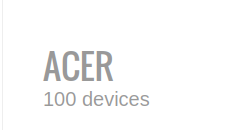

I will apply the script to all the brands and collect their phone models.

In [12]:
all_phone_links = list()
all_phone_links.extend(get_all_links(str(page)) for page in all_first_pages)

Going to https://www.gsmarena.com/acer-phones-f-59-0-p2.php
Going to https://www.gsmarena.com/acer-phones-f-59-0-p3.php
Finished with brand https://www.gsmarena.com/acer-phones-f-59-0-p3.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p2.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p3.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p4.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p5.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p6.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p7.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p8.php
Going to https://www.gsmarena.com/alcatel-phones-f-5-0-p9.php
Finished with brand https://www.gsmarena.com/alcatel-phones-f-5-0-p9.php
Going to https://www.gsmarena.com/allview-phones-f-88-0-p2.php
Going to https://www.gsmarena.com/allview-phones-f-88-0-p3.php
Going to https://www.gsmarena.com/allview-phones-f-88-0-p4.php
Finished with brand https://www.gsmarena.com/allvie

All phones parsed!

In [13]:
all_phone_links

[['https://www.gsmarena.com/acer_acerone_liquid_s272e4-13757.php',
  'https://www.gsmarena.com/acer_acerone_liquid_s162e4-13756.php',
  'https://www.gsmarena.com/acer_chromebook_tab_10-9139.php',
  'https://www.gsmarena.com/acer_iconia_talk_s-8306.php',
  'https://www.gsmarena.com/acer_liquid_z6_plus-8305.php',
  'https://www.gsmarena.com/acer_liquid_z6-8304.php',
  'https://www.gsmarena.com/acer_iconia_tab_10_a3_a40-8080.php',
  'https://www.gsmarena.com/acer_liquid_x2-8034.php',
  'https://www.gsmarena.com/acer_liquid_jade_2-7956.php',
  'https://www.gsmarena.com/acer_liquid_zest_plus-8059.php',
  'https://www.gsmarena.com/acer_liquid_zest-7955.php',
  'https://www.gsmarena.com/acer_predator_8-7750.php',
  'https://www.gsmarena.com/acer_liquid_jade_primo-7650.php',
  'https://www.gsmarena.com/acer_liquid_z330-7530.php',
  'https://www.gsmarena.com/acer_liquid_z320-7531.php',
  'https://www.gsmarena.com/acer_liquid_z630s-7529.php',
  'https://www.gsmarena.com/acer_liquid_z630-7528.php

In [14]:
import pandas as pd

The data about the links will be stored in a dataframe, exported to csv file.

For this, the brand names will be extracted from the list of lists all_phone_links.

In [23]:
brand_names = list()
for col in all_first_pages:
    brand_names.append(col.split('/')[3].split('-')[0])

In [24]:
brand_names

['acer',
 'alcatel',
 'allview',
 'amazon',
 'amoi',
 'apple',
 'archos',
 'asus',
 'at&t',
 'benefon',
 'benq',
 'benq_siemens',
 'bird',
 'blackberry',
 'blackview',
 'blu',
 'bosch',
 'bq',
 'casio',
 'cat',
 'celkon',
 'chea',
 'coolpad',
 'cubot',
 'dell',
 'doogee',
 'emporia',
 'energizer',
 'ericsson',
 'eten',
 'fairphone',
 'fujitsu_siemens',
 'garmin_asus',
 'gigabyte',
 'gionee',
 'google',
 'haier',
 'hmd',
 'honor',
 'hp',
 'htc',
 'huawei',
 'i_mate',
 'i_mobile',
 'icemobile',
 'infinix',
 'innostream',
 'inq',
 'intex',
 'itel',
 'jolla',
 'karbonn',
 'kyocera',
 'lava',
 'leeco',
 'lenovo',
 'lg',
 'maxon',
 'maxwest',
 'meizu',
 'micromax',
 'microsoft',
 'mitac',
 'mitsubishi',
 'modu',
 'motorola',
 'mwg',
 'nec',
 'neonode',
 'niu',
 'nokia',
 'nothing',
 'nvidia',
 'o2',
 'oneplus',
 'oppo',
 'orange',
 'oscal',
 'oukitel',
 'palm',
 'panasonic',
 'pantech',
 'parla',
 'philips',
 'plum',
 'posh',
 'prestigio',
 'qmobile',
 'qtek',
 'razer',
 'realme',
 'sagem',


In [25]:
(len(brand_names), len(set(brand_names))) # check for duplicates

(125, 125)

In [26]:
df = pd.DataFrame(all_phone_links).transpose()
df.columns = brand_names
df.head()

,acer,alcatel,allview,amazon,amoi,apple,archos,asus,at&t,benefon,...,vodafone,wiko,wnd,xcute,xiaomi,xolo,yezz,yota,yu,zte
0,https://www.gsmarena.com/acer_acerone_liquid_s...,https://www.gsmarena.com/alcatel_1b_(2022)-117...,https://www.gsmarena.com/allview_soul_x7_pro-1...,https://www.gsmarena.com/amazon_fire_max_11-12...,https://www.gsmarena.com/amoi_e860-2038.php,https://www.gsmarena.com/apple_ipad_air_13_(20...,https://www.gsmarena.com/archos_diamond-9593.php,https://www.gsmarena.com/asus_zenfone_12_ultra...,https://www.gsmarena.com/at&t_quickfire-2598.php,https://www.gsmarena.com/benefon_twig_discover...,...,https://www.gsmarena.com/vodafone_smart_v10-97...,https://www.gsmarena.com/wiko_t20-13118.php,https://www.gsmarena.com/wnd_wind_van_gogh_210...,https://www.gsmarena.com/xcute_dv80-1495.php,https://www.gsmarena.com/xiaomi_poco_f7_ultra-...,https://www.gsmarena.com/xolo_era_2x-8520.php,https://www.gsmarena.com/yezz_art_3s-12101.php,https://www.gsmarena.com/yota_yotaphone_3-8727...,https://www.gsmarena.com/yu_ace-9308.php,https://www.gsmarena.com/zte_nubia_focus_2_ult...
1,https://www.gsmarena.com/acer_acerone_liquid_s...,https://www.gsmarena.com/alcatel_1l_pro_(2021)...,https://www.gsmarena.com/allview_soul_x7_style...,https://www.gsmarena.com/amazon_fire_hd_8_plus...,https://www.gsmarena.com/amoi_e78-2037.php,https://www.gsmarena.com/apple_ipad_air_11_(20...,https://www.gsmarena.com/archos_oxygen_68xl-95...,https://www.gsmarena.com/asus_rog_phone_9_pro-...,https://www.gsmarena.com/at&t_smt5700-2603.php,https://www.gsmarena.com/benefon_twig_discover...,...,https://www.gsmarena.com/vodafone_smart_n10-97...,https://www.gsmarena.com/wiko_hi_enjoy_60s-126...,https://www.gsmarena.com/wnd_wind_duo_2300-216...,https://www.gsmarena.com/xcute_dv50-1494.php,https://www.gsmarena.com/xiaomi_poco_f7_pro-13...,https://www.gsmarena.com/xolo_era_2-8395.php,https://www.gsmarena.com/yezz_max_3_ultra-1209...,https://www.gsmarena.com/yota_yotaphone_2-6959...,https://www.gsmarena.com/yu_yureka_2-8864.php,https://www.gsmarena.com/zte_nubia_focus_2-137...
2,https://www.gsmarena.com/acer_chromebook_tab_1...,https://www.gsmarena.com/alcatel_1_(2021)-1098...,https://www.gsmarena.com/allview_viva_803g-103...,https://www.gsmarena.com/amazon_fire_hd_8_(202...,https://www.gsmarena.com/amoi_e76-2036.php,https://www.gsmarena.com/apple_ipad_(2025)-137...,https://www.gsmarena.com/archos_oxygen_63-9595...,https://www.gsmarena.com/asus_rog_phone_9_fe-1...,https://www.gsmarena.com/at&t_mustang-2602.php,https://www.gsmarena.com/benefon_q-42.php,...,https://www.gsmarena.com/vodafone_smart_e9-948...,https://www.gsmarena.com/wiko_t60-12477.php,https://www.gsmarena.com/wnd_wind_duo_2200-216...,https://www.gsmarena.com/xcute_dv2-1481.php,https://www.gsmarena.com/xiaomi_redmi_a5_4g-13...,https://www.gsmarena.com/xolo_era_1x-8339.php,https://www.gsmarena.com/yezz_max_3_plus-12098...,https://www.gsmarena.com/yota_yotaphone-6961.php,https://www.gsmarena.com/yu_yunique_2-8788.php,https://www.gsmarena.com/zte_nubia_neo_3_gt-13...
3,https://www.gsmarena.com/acer_iconia_talk_s-83...,https://www.gsmarena.com/alcatel_3l_(2021)-106...,https://www.gsmarena.com/allview_v4_viper_pro-...,https://www.gsmarena.com/amazon_fire_hd_10_plu...,https://www.gsmarena.com/amoi_e72-2032.php,https://www.gsmarena.com/apple_iphone_16e-1339...,https://www.gsmarena.com/archos_oxygen_57-9596...,https://www.gsmarena.com/asus_rog_phone_9-1350...,https://www.gsmarena.com/at&t_8525-2601.php,https://www.gsmarena.com/benefon_track-43.php,...,https://www.gsmarena.com/vodafone_smart_x9-948...,https://www.gsmarena.com/wiko_5g-12049.php,https://www.gsmarena.com/wnd_wind_duo_2100-216...,https://www.gsmarena.com/xcute_dv1-1480.php,https://www.gsmarena.com/xiaomi_redmi_note_14s...,https://www.gsmarena.com/xolo_era_x-7959.php,https://www.gsmarena.com/yezz_max_3-12099.php,None,https://www.gsmarena.com/yu_yureka_black-8714.php,https://www.gsmarena.com/zte_nubia_neo_3-13711...
4,https://www.gsmarena.com/acer_liq

In [27]:
df.to_csv('all_phone_links_28_03_2025.csv', index=False)